<a href="https://colab.research.google.com/github/ZahraDehghani99/AI-Internship/blob/master/Speech%20models/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition

## Load dataset from hugging face hub

https://huggingface.co/docs/transformers/tasks/audio_classification#audio-classification

In [1]:
!pip install -q transformers datasets evaluate

In [2]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
from datasets import load_dataset, Audio

iemocap_audio = load_dataset("Zahra99/IEMOCAP_Audio")

  0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
iemocap_audio

DatasetDict({
    session2: Dataset({
        features: ['audio', 'label'],
        num_rows: 1023
    })
    session1: Dataset({
        features: ['audio', 'label'],
        num_rows: 1085
    })
    session3: Dataset({
        features: ['audio', 'label'],
        num_rows: 1151
    })
    session5: Dataset({
        features: ['audio', 'label'],
        num_rows: 1241
    })
    session4: Dataset({
        features: ['audio', 'label'],
        num_rows: 1031
    })
})

In [6]:
iemocap_audio["session1"].features

{'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'label': ClassLabel(names=['ang', 'hap', 'neu', 'sad'], id=None)}

for path we have only the file name not all of the directory, although we have full directory before we create hugging face dataset.

In [7]:
iemocap_audio["session1"][0]

{'audio': {'path': 'Ses01M_impro01_F000.wav',
  'array': array([ 0.00543213,  0.00488281,  0.00537109, ...,  0.0017395 ,
         -0.00650024, -0.01904297]),
  'sampling_rate': 16000},
 'label': 0}

In [8]:
labels = iemocap_audio["session1"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [9]:
id2label[str(0)]

'ang'

## Split train, valid and test

let's split trian, valid and test dataset. We use the first three sessions of the IEMOCAP dataset as training, the fourth session as validation and fifth session as the test set.

In [10]:
from datasets import concatenate_datasets

iemocap_train = concatenate_datasets([iemocap_audio['session1'], iemocap_audio['session2'], iemocap_audio['session3']])  
iemocap_valid = iemocap_audio['session4']
iemocap_test = iemocap_audio['session5']

In [11]:
iemocap_train

Dataset({
    features: ['audio', 'label'],
    num_rows: 3259
})

In [12]:
iemocap_train[1084]

{'audio': {'path': 'Ses01M_script01_1_F043.wav',
  'array': array([ 0.00128174,  0.00042725,  0.00018311, ..., -0.00402832,
         -0.00479126, -0.00427246]),
  'sampling_rate': 16000},
 'label': 0}

In [13]:
iemocap_train[1085]

{'audio': {'path': 'Ses02F_script01_2_M001.wav',
  'array': array([-2.74658203e-04,  9.15527344e-05,  1.28173828e-03, ...,
          5.43212891e-03,  5.43212891e-03,  5.40161133e-03]),
  'sampling_rate': 16000},
 'label': 2}

Let's put these splits in one `DataDict` and create a new dataset with them.

In [14]:
from datasets import DatasetDict
iemocap = DatasetDict({
                    "train": iemocap_train,   
                    "valid": iemocap_valid,
                    "test": iemocap_test
})

In [15]:
iemocap

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 3259
    })
    valid: Dataset({
        features: ['audio', 'label'],
        num_rows: 1031
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 1241
    })
})

Let's show the some audio files.

In [54]:
import random
from IPython.display import Audio, display

idx_lst = [0, 1084, 1085, 2107, 2108, 3258]

for idx in idx_lst:
    # rand_idx = random.randint(0, len(iemocap["train"])-1)
    example = iemocap["train"][idx]
    audio = example["audio"]

    print(f'Utterance: {example["audio"]["path"]}')
    print(f'Label: {id2label[str(example["label"])]}')
    print(f'Shape: {audio["array"].shape}, sampling rate: {audio["sampling_rate"]}')
    display(Audio(audio["array"], rate=audio["sampling_rate"]))
    print()

Utterance: Ses01M_impro01_F000.wav
Label: ang
Shape: (27039,), sampling rate: 16000



Utterance: Ses01M_script01_1_F043.wav
Label: ang
Shape: (50416,), sampling rate: 16000



Utterance: Ses02F_script01_2_M001.wav
Label: neu
Shape: (50079,), sampling rate: 16000



Utterance: Ses02M_impro04_M022.wav
Label: sad
Shape: (50060,), sampling rate: 16000



Utterance: Ses03M_script01_2_F000.wav
Label: ang
Shape: (39749,), sampling rate: 16000



Utterance: Ses03M_impro03_M039.wav
Label: hap
Shape: (81949,), sampling rate: 16000


## Define needed functions

### Defining the performance metrics

In [ ]:
# import evaluate

# accuracy = evaluate.load("accuracy")

In [16]:
from sklearn.metrics import accuracy_score, f1_score

# def compute_metrics(eval_pred):
#     predictions = np.argmax(eval_pred.predictions, axis=1)
#     return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

def compute_metrics(pred):
  labels = pred.label_ids 
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}    

### Defining Confusion matrix

In [17]:
classes = ["ang", "hap", "neu", "sad"]

In [39]:
def confusion_matrix(y_test, y_pred):
  labels = [i for i in range(len(list(set(y_test))))]
  df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index = labels,
                columns = labels)
  plt.figure(figsize=(8,6))
  ax= plt.subplot()
  sns.heatmap(df_cm, annot=True, cmap="YlGnBu" ,fmt='g', ax=ax)
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  class_names= classes
  ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
  plt.tight_layout()
  plt.show()

## Emotion Recognition using Wav2vec v1.0 Model

### Load feature extractor

In [19]:
from transformers import AutoFeatureExtractor

model_checkpoint = "facebook/wav2vec2-base"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

In [20]:
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [21]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True
    )
    return inputs

In [22]:
encoded_iemocap_audio = iemocap.map(preprocess_function, remove_columns="audio", batched=True)

In [23]:
encoded_iemocap_audio

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 3259
    })
    valid: Dataset({
        features: ['label', 'input_values'],
        num_rows: 1031
    })
    test: Dataset({
        features: ['label', 'input_values'],
        num_rows: 1241
    })
})

In [24]:
encoded_iemocap_audio['train'][0]

{'label': 0,
 'input_values': [0.03782178461551666,
  0.03514855355024338,
  0.0375247597694397,
  0.033811938017606735,
  0.038564346730709076,
  0.04361378774046898,
  0.04287122189998627,
  0.04019799083471298,
  0.03366342559456825,
  0.027871422469615936,
  0.0281684473156929,
  0.03232681006193161,
  0.03425747528672218,
  0.032623834908008575,
  0.03217829763889313,
  0.03514855355024338,
  0.04019799083471298,
  0.04613850638270378,
  0.05311861261725426,
  0.05920764058828354,
  0.060098715126514435,
  0.0544552281498909,
  0.04435634985566139,
  0.037376247346401215,
  0.035000041127204895,
  0.03232681006193161,
  0.029505064710974693,
  0.024901164695620537,
  0.021188342943787575,
  0.022970497608184814,
  0.025495216250419617,
  0.030247628688812256,
  0.03351491317152977,
  0.028316961601376534,
  0.027277370914816856,
  0.032623834908008575,
  0.032623834908008575,
  0.025346703827381134,
  0.014505262486636639,
  0.013168646953999996,
  0.02326752245426178,
  0.0272773

In [25]:
len(encoded_iemocap_audio['train'][0]['input_values'])

16000

### Fine-Tunning Transformer

In [26]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['project_q.weight', 'project_q.bias', 'quantizer.codevectors', 'quantizer.weight_proj.weight', 'project_hid.weight', 'project_hid.bias', 'quantizer.weight_proj.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector

In [27]:
model

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), strid

### Training the model

In [28]:
batch_size = 32 
# logging_steps = len(encoded_iemocap_audio["train"]) // batch_size
training_args = TrainingArguments(
    output_dir=f"{model_checkpoint}-finetuned-iemocap3", 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4, ### ??
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    warmup_ratio=0.1, ###?
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy", ###?
    push_to_hub=True,
)

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_iemocap_audio["train"],
    eval_dataset=encoded_iemocap_audio["valid"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/Zahra99/wav2vec2-base-finetuned-iemocap3 into local empty directory.


In [30]:
import torch
torch.cuda.empty_cache()

In [31]:
trainer.train()

***** Running training *****
  Num examples = 3259
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 50
  Number of trainable parameters = 94569604


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,1.282700,1.281938,0.370514,0.292061
1,1.200200,1.241142,0.386033,0.321295


***** Running Evaluation *****
  Num examples = 1031
  Batch size = 32
Saving model checkpoint to facebook/wav2vec2-base-finetuned-iemocap3/checkpoint-25
Configuration saved in facebook/wav2vec2-base-finetuned-iemocap3/checkpoint-25/config.json
Model weights saved in facebook/wav2vec2-base-finetuned-iemocap3/checkpoint-25/pytorch_model.bin
Feature extractor saved in facebook/wav2vec2-base-finetuned-iemocap3/checkpoint-25/preprocessor_config.json
Feature extractor saved in facebook/wav2vec2-base-finetuned-iemocap3/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1031
  Batch size = 32
Saving model checkpoint to facebook/wav2vec2-base-finetuned-iemocap3/checkpoint-50
Configuration saved in facebook/wav2vec2-base-finetuned-iemocap3/checkpoint-50/config.json
Model weights saved in facebook/wav2vec2-base-finetuned-iemocap3/checkpoint-50/pytorch_model.bin
Feature extractor saved in facebook/wav2vec2-base-finetuned-iemocap3/checkpoint-50/preprocessor_config.json
Featur

TrainOutput(global_step=50, training_loss=1.2751288604736328, metrics={'train_runtime': 253.2088, 'train_samples_per_second': 25.742, 'train_steps_per_second': 0.197, 'total_flos': 5.8639206934656e+16, 'train_loss': 1.2751288604736328, 'epoch': 1.98})

### Evaluation on the Test set

In [32]:
preds_output_test = trainer.predict(encoded_iemocap_audio["test"])

***** Running Prediction *****
  Num examples = 1241
  Batch size = 32


In [33]:
preds_output_test.metrics

{'test_loss': 1.2197582721710205,
 'test_accuracy': 0.45447219983883963,
 'test_f1': 0.41802851393335233,
 'test_runtime': 14.9285,
 'test_samples_per_second': 83.13,
 'test_steps_per_second': 2.612}

In [34]:
y_test = np.array(encoded_iemocap_audio["test"]["label"])

In [35]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

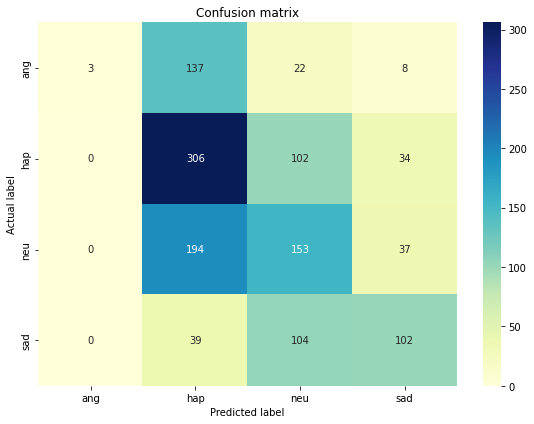

In [40]:
confusion_matrix(y_test, y_preds_test)

In [41]:
classification_report(y_test, y_preds_test)

'              precision    recall  f1-score   support\n\n           0       1.00      0.02      0.03       170\n           1       0.45      0.69      0.55       442\n           2       0.40      0.40      0.40       384\n           3       0.56      0.42      0.48       245\n\n    accuracy                           0.45      1241\n   macro avg       0.60      0.38      0.37      1241\nweighted avg       0.53      0.45      0.42      1241\n'

### Evaluation on one example

In [42]:
from datasets import load_dataset, Audio

dataset = load_dataset("Zahra99/IEMOCAP_Audio", split="session5")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
sampling_rate = dataset.features["audio"].sampling_rate
audio_file = dataset[0]["audio"]["array"]

In [43]:
dataset

Dataset({
    features: ['audio', 'label'],
    num_rows: 1241
})

In [44]:
from transformers import pipeline

classifier = pipeline("audio-classification", model="Zahra99/wav2vec2-base-finetuned-iemocap3")
classifier(audio_file)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Zahra99--wav2vec2-base-finetuned-iemocap3/snapshots/0960cc028ba6fecbbd8ba7099de2e79ae72e65e9/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "Zahra99/wav2vec2-base-finetuned-iemocap3",
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--Zahra99--wav2vec2-base-finetuned-iemocap3/snapshots/0960cc028ba6fecbbd8ba7099de2e79ae72e65e9/pytorch_model.bin
All model checkpoint weights were used when initializing Wav2Vec2ForSequenceClassification.

All the weights of Wav2Vec2ForSequenceClassification were initialized from the model checkpoint at Zahra99/wav2vec2-base-finetuned-iemocap3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Wav2Vec2ForSequenceClassification for predictions without further training.


loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--Zahra99--wav2vec2-base-finetuned-iemocap3/snapshots/0960cc028ba6fecbbd8ba7099de2e79ae72e65e9/preprocessor_config.json
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}



[{'score': 0.34139302372932434, 'label': 'neu'},
 {'score': 0.3270171880722046, 'label': 'hap'},
 {'score': 0.21512968838214874, 'label': 'ang'},
 {'score': 0.11646004766225815, 'label': 'sad'}]

You can also manually replicate the results of the pipeline if you’d like:

In [45]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("Zahra99/wav2vec2-base-finetuned-iemocap3")
inputs = feature_extractor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--Zahra99--wav2vec2-base-finetuned-iemocap3/snapshots/0960cc028ba6fecbbd8ba7099de2e79ae72e65e9/preprocessor_config.json
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}



In [46]:
inputs

{'input_values': tensor([[-0.1419, -0.1145, -0.0490,  ...,  0.0989,  0.0630, -0.0152]])}

In [47]:
import torch
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained("Zahra99/wav2vec2-base-finetuned-iemocap2")
with torch.no_grad():
    logits = model(**inputs).logits

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Zahra99--wav2vec2-base-finetuned-iemocap2/snapshots/5016f56c149cbc34fbba23e3fc63ef496b5a6189/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "Zahra99/wav2vec2-base-finetuned-iemocap2",
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--Zahra99--wav2vec2-base-finetuned-iemocap2/snapshots/5016f56c149cbc34fbba23e3fc63ef496b5a6189/pytorch_model.bin
All model checkpoint weights were used when initializing Wav2Vec2ForSequenceClassification.

All the weights of Wav2Vec2ForSequenceClassification were initialized from the model checkpoint at Zahra99/wav2vec2-base-finetuned-iemocap2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Wav2Vec2ForSequenceClassification for predictions without further training.


In [48]:
logits

tensor([[-0.8183,  0.1450,  0.9943, -0.0509]])

In [49]:
predicted_class_ids = torch.argmax(logits).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

'neu'